# **California housing prices**
**Done by:** Saja Abdalaal

## Objectives
-----------

This notebook aims to build a machine learning model to predict the median
housing price in any district in the data (which represents California districts), given all the other metrics.

## Problem description (Machine learning point of view)
-------

This is a **Supervised learning task** since the dataset is labeled. It's also a **Regression task** since the target value (median housing price) is continuous.

We're going to use multiple features to predict only the price (the target value), so it's **Multiple, Univariate regression problem**.

Moreover, we're going to use **Batch learning** since the data is small and there is no continuous flow of data coming into the system.

## Import Data/libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
housing_df = pd.read_csv(url)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


--------------
After showing the first 5 rows from the data, we need to confirm attributes data types, dataset size, and if there're any null values that could cause any problems in the future while preparing the model.

In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Notice that:
- The ***total_bedrooms*** attribute has only 20,433 nonnull values, meaning that 207
districts are missing this feature.
- Fortunately, all attributes are of the type ***float64*** (except ***ocean_proximity*** attribute).

## Test set

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)

After splitting data into training and testing sets, we need to ensure that the test set is representative of the various categories of incomes in the whole dataset (`we will see later that meadian income is the most correlated feature with median price`).</br>
So, we're using **Stratified Sampling** techniqe for that purpose.

In [5]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                           bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                           labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

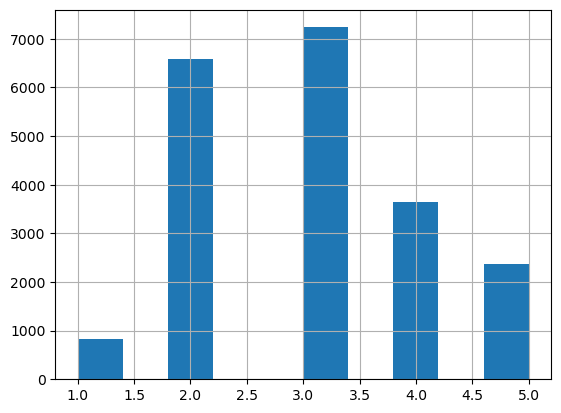

In [6]:
housing_df["income_cat"].hist()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
  strat_train_set = housing_df.loc[train_index]
  strat_test_set = housing_df.loc[test_index]

In [8]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)


## Data Preprocessing

In this section we're going to preprocess the data to get the most out of it when it comes to EDA (Exploratory Data Analysis) and Machine learning modeling.

### Handling Missing/Duplicate values

In [9]:
# preprocessing train set only
housing_df = strat_train_set.copy()
strat_train_set.shape

(16512, 10)

In [10]:
housing_df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
(158/16512)

0.009568798449612403

Again, we can notice that total_bedrooms attribute has 207 missing values, such a problem could be solve by either dropping these values or filling them with some sort of approximation (mean of values for example) </br>
Here we are going to fill them with the median.

In [12]:
median = housing_df["total_bedrooms"].median()
housing_df["total_bedrooms"].fillna(median, inplace=True)
housing_df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

--------------------
The following code show us that there're no duplicate rows in this dataset

In [13]:
housing_df.duplicated().sum()

0

### Handling Catigorical Attributes

In [14]:
#Get unique values in each attribute
housing_df.nunique()

longitude               825
latitude                839
housing_median_age       52
total_rooms            5494
total_bedrooms         1810
population             3619
households             1691
median_income         10905
median_house_value     3669
ocean_proximity           5
dtype: int64

From the previous code we can notice that ***ocean_proximity*** is the only catigorical attribute we have, and handling this case comes as follows:


**1.** Count each category appearance

In [15]:
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

**2.** visualize catigories

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>

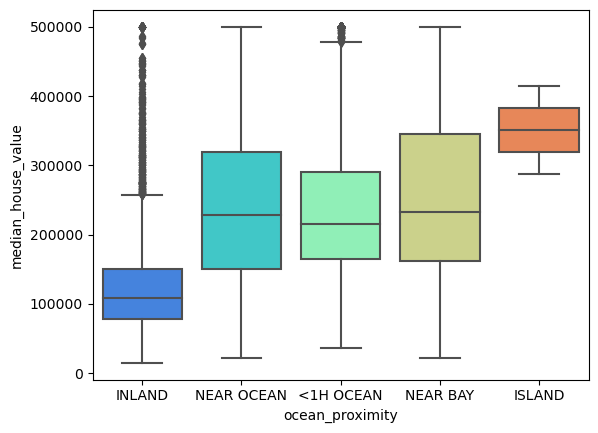

In [16]:
sns.boxplot(x='ocean_proximity',y='median_house_value',data=housing_df,palette='rainbow')

**3.** Convert categories to numerical values using `get_dummies()` function.

Note: `We used one hot encoder to avoid any potential of ranking`

In [17]:
housing_df = pd.concat([housing_df, pd.get_dummies(housing_df['ocean_proximity'], drop_first=True)], axis=1)
housing_df = housing_df.drop('ocean_proximity', axis=1)

In [18]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,1,0,0,0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,0,0,0,1
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,1,0,0,0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,0,0,0,1
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,0,0,0,0


## Exploratory Data Analysis (EDA)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

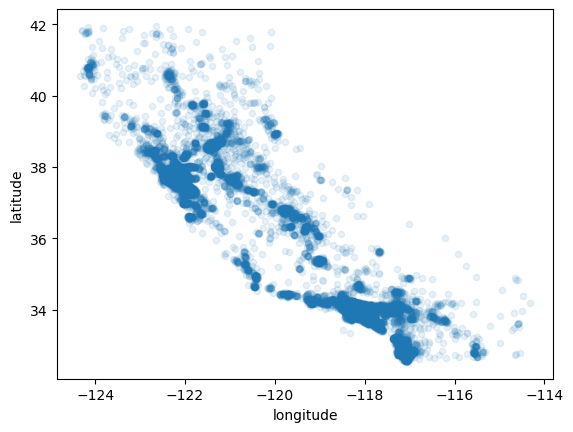

In [19]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

We can clearly see the high-density areas, namely the
Bay Area and around Los Angeles and San Diego, plus a long line of fairly high
density in the Central Valley, in particular around Sacramento and Fresno.


-----------------------

This image tells that the housing prices are very much related to the
location (e.g., close to the ocean) and to the population density.

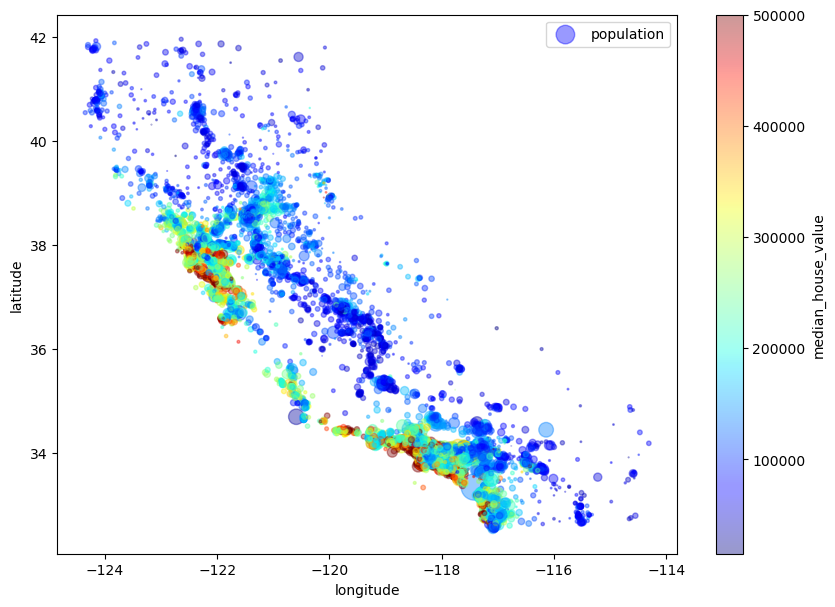

In [20]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing_df["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

- `The radius of each circle
represents the district’s population (option s), and the color represents the price
(option c)`

**Correlation**

<AxesSubplot:>

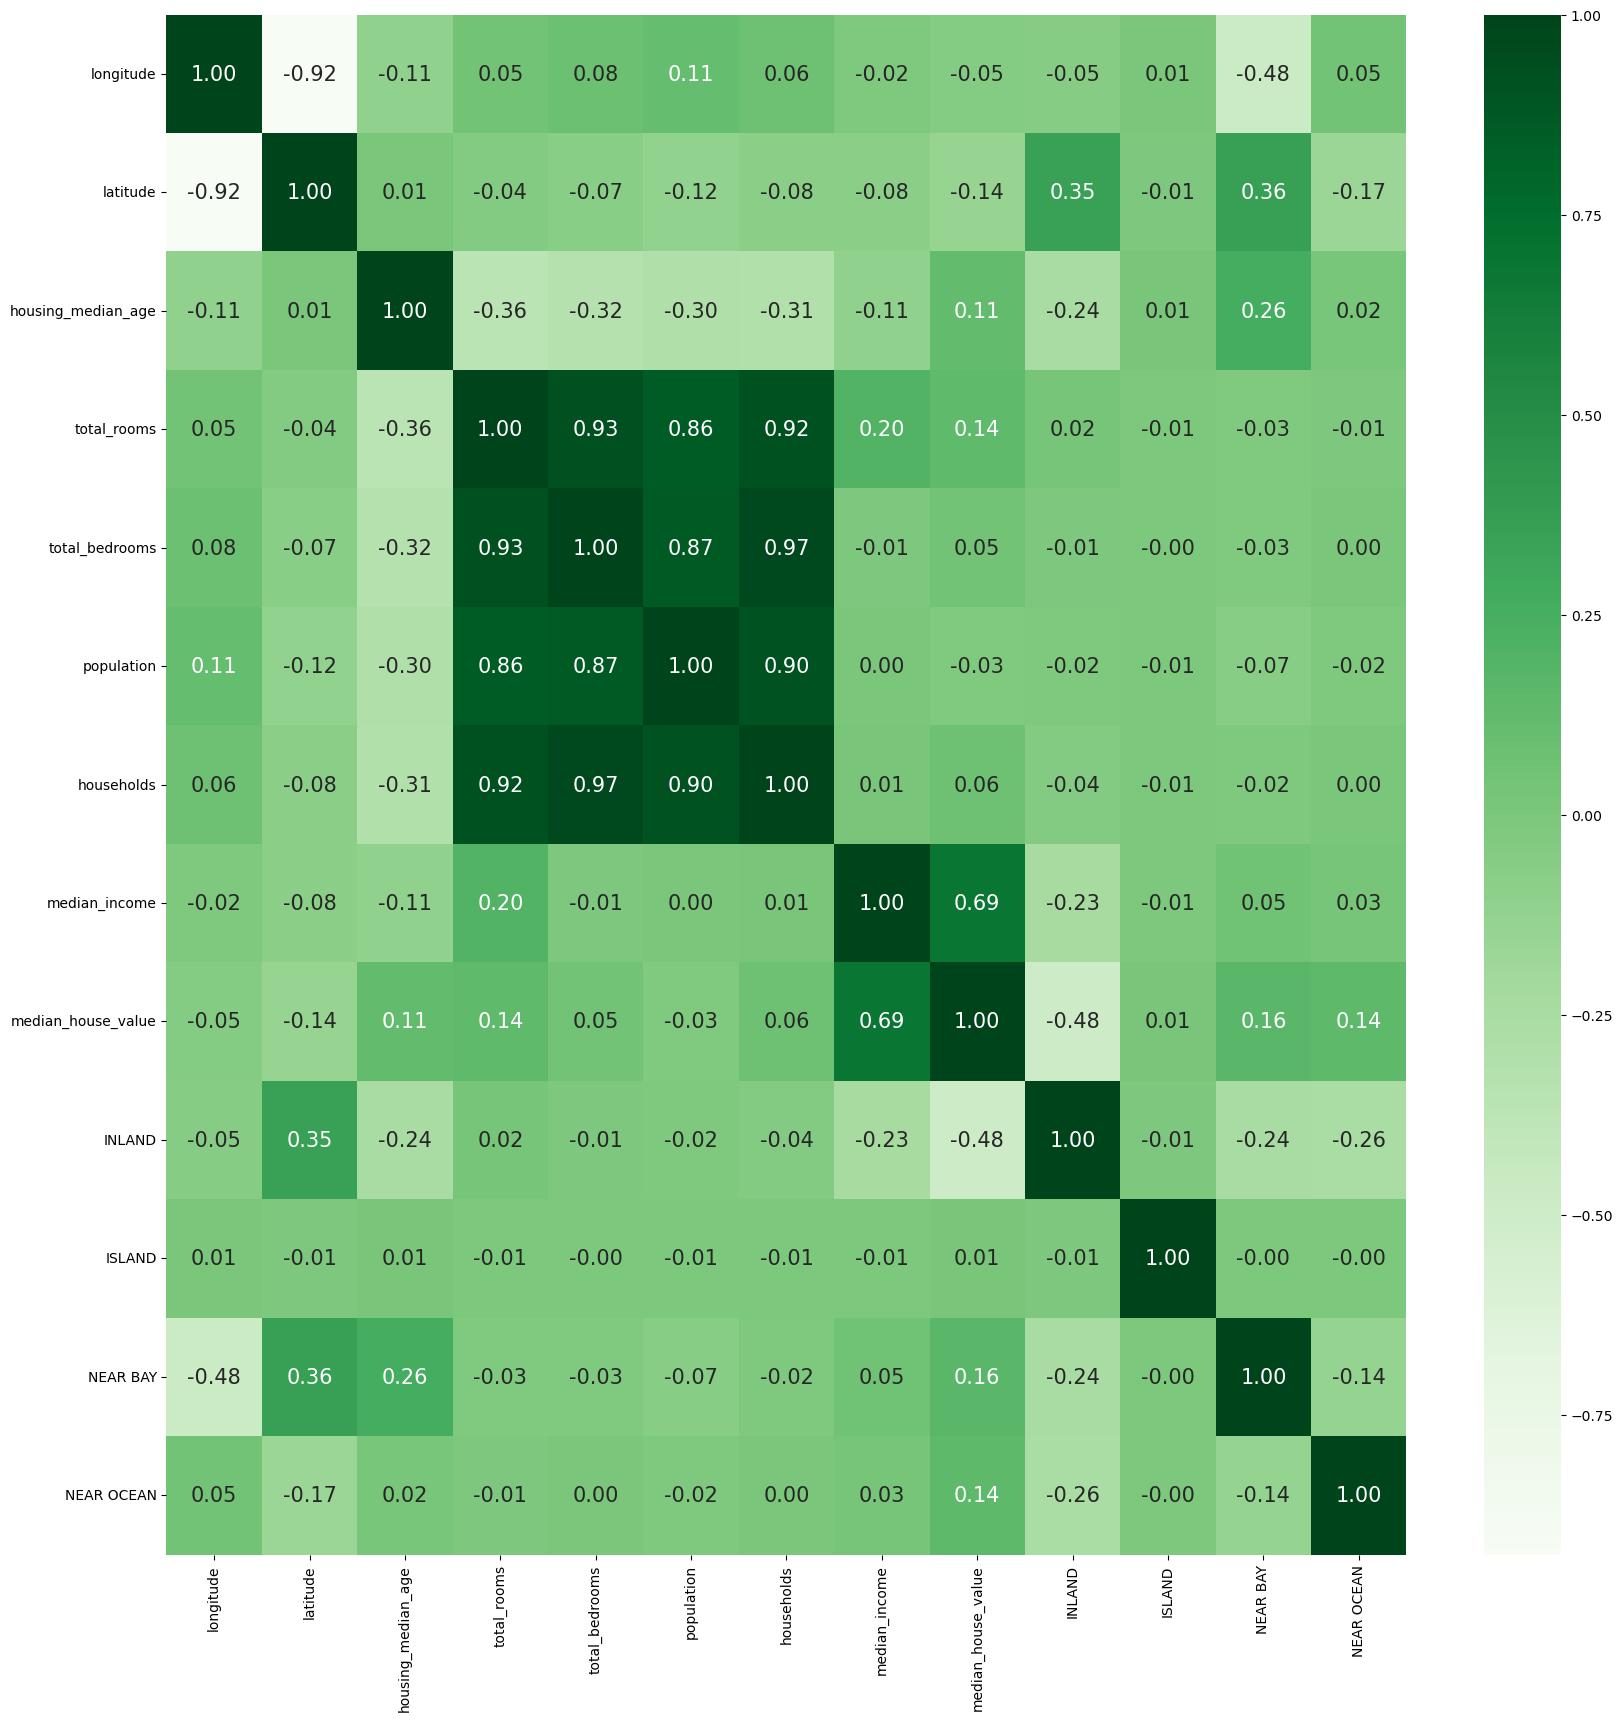

In [21]:
corr = housing_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='Greens')

From the above heatmap (which represents the correlation between features) we can notice that the most correlated feature with the target is 'median_income', so we have to keep in mind to
**ensure that the test set is representative of the various categories of incomes in
the whole dataset**

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

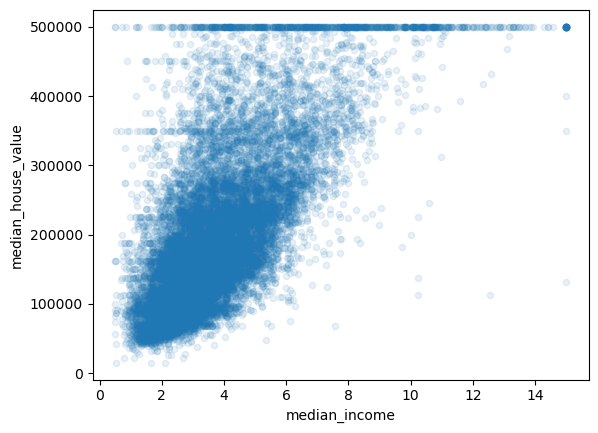

In [22]:
housing_df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

----------------------------------

**Experimenting with Attribute Combinations**
The total number of rooms in a district is not very useful if we don’t know how
many households there are. So, We are interested in the number of rooms per
household.
 Similarly, the total number of bedrooms by itself is not very useful, as well as the population.

In [23]:
housing_df["rooms_per_household"] = housing_df["total_rooms"]/housing_df["households"]
housing_df["bedrooms_per_room"] = housing_df["total_bedrooms"]/housing_df["total_rooms"]
housing_df["population_per_household"]=housing_df["population"]/housing_df["households"]


After creating new features, let’s test the correlation matrix again

In [24]:
housing_df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
NEAR BAY                    0.158691
rooms_per_household         0.146255
NEAR OCEAN                  0.137332
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047735
ISLAND                      0.013708
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.234212
INLAND                     -0.482853
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated
with the median house value than the total number of rooms or bedrooms! <br>
Apparently houses with a lower bedroom/room ratio tend to be more expensive.



**Data distribution**

In [25]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884,207005.322372,0.318677,0.000121,0.111858,0.128634,5.440406,0.213698,3.096469
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931,115701.297250,0.465978,0.011005,0.315201,0.334804,2.611696,0.065344,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,1.130435,0.036980,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950,119800.000000,0.000000,0.000000,0.000000,0.000000,4.442168,0.175054,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,0.000000,0.000000,0.000000,0.000000,5.232342,0.203046,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325,263900.000000,1.000000,0.000000,0.000000,0.000000,6.056361,0.240126,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,141.909091,2.811688,1243.333333


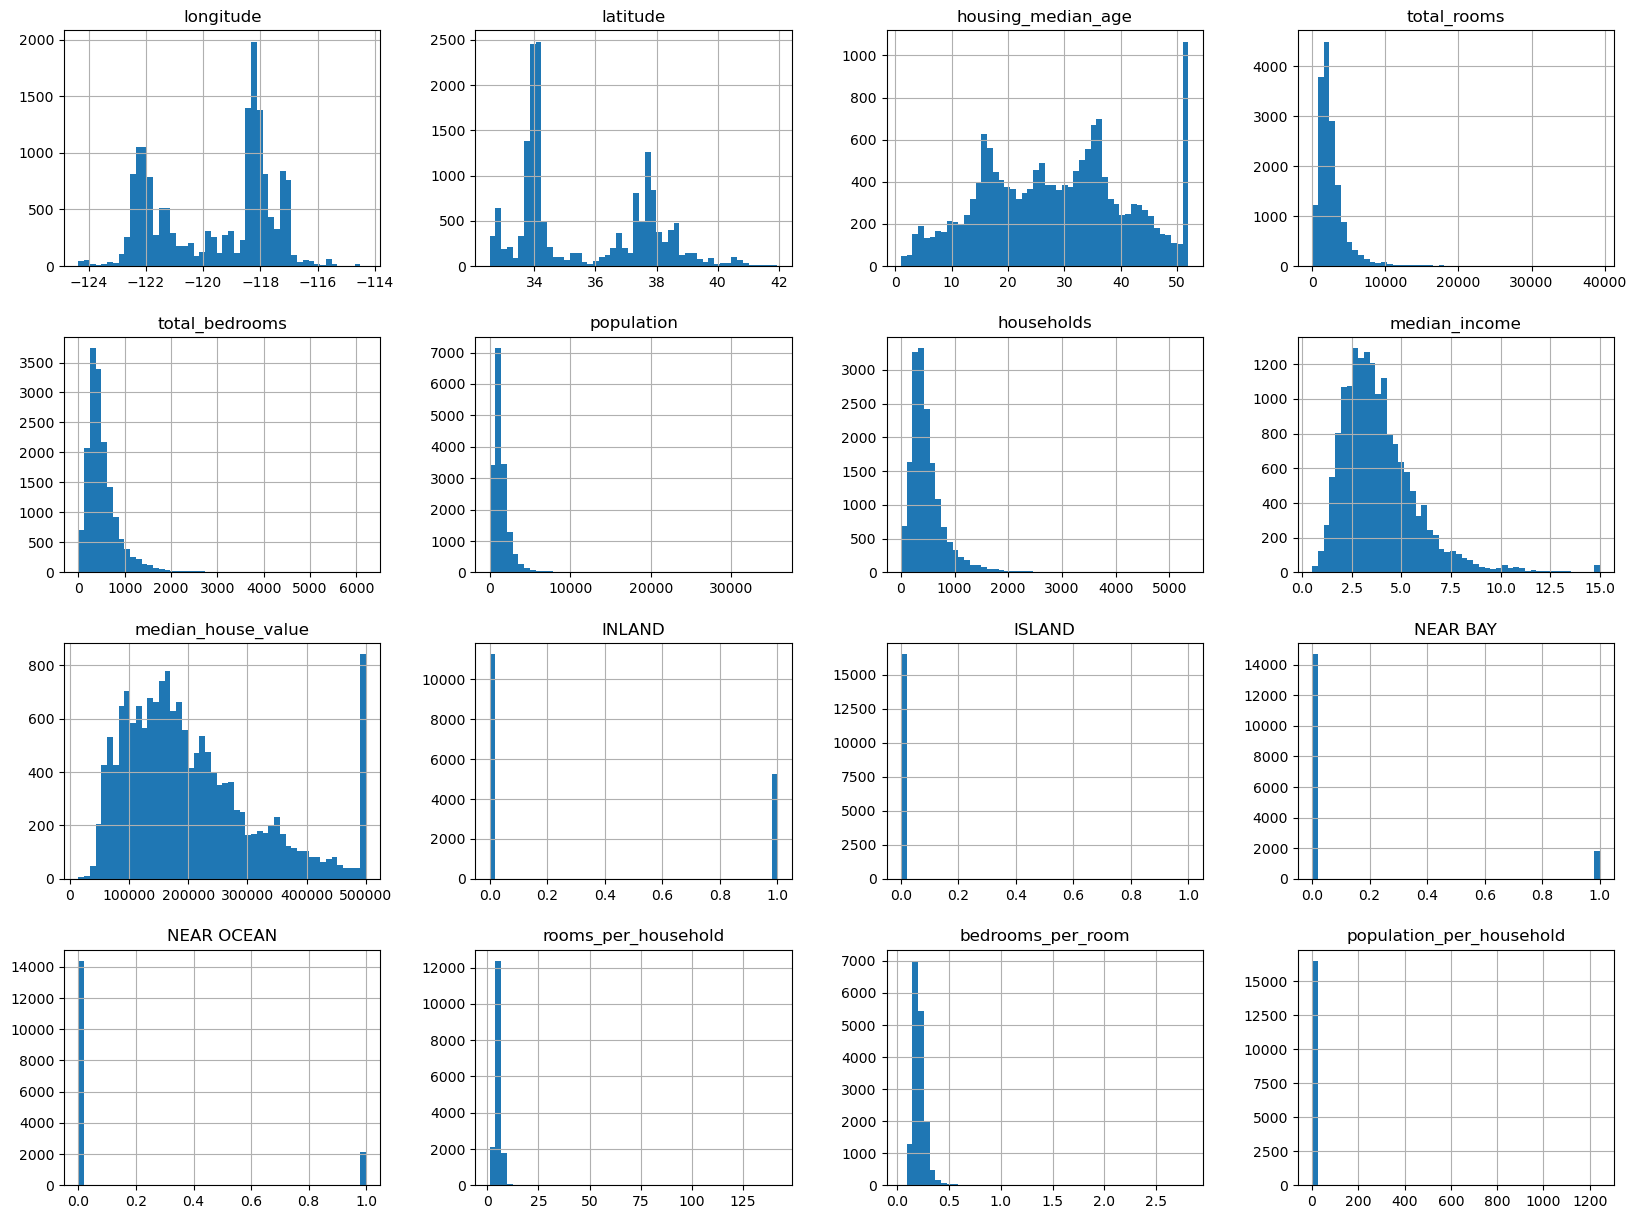

In [26]:
housing_df.hist(bins=50, figsize=(20,15))
plt.show()

#### From the above histogram figure notice that:
1. First, the median income attribute does not look like it is expressed in
US dollars (USD), that's because data has been scaled and capped at 15, and the numbers represent roughly tens of
thousands of dollars (e.g., 3 actually means about $30,000).

2. The housing median age and the median house value were also capped.

3. Attributes have very different scales.

4. Some attributes are represented as skewed distributions.
----------

### Scale data

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_num = housing_df.copy()
# df of only ratio attributes
for col in housing_df:
  if housing_df[col].nunique() < 5:
    housing_num = housing_num.drop(col, axis=1)

housing_num = scaler.fit_transform(housing_num)
housing_num

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
        -0.12112176,  0.00622264],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.81086696, -0.04081077],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.33827252, -0.07537122],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
         0.32286937, -0.03743619],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.45702273, -0.05915604],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
        -0.12169672,  0.00657083]])

### Data Pipeline

Now, all of the previous preprocessing and feature engineering will now be applied to the raw data using Data Pipeline


------------------

First, Split lable from the dataset

**`Note: we used the unprocessed data to split features and targets, That's because we will perform all the previous preprocessing in this data once again in the data pipeline.`**

In [28]:
# splitting the train/test sets into x and y
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

Data Pipeline

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
  
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_df.values)


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy="median")),
  ('attribs_adder', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler()),])

housing_num = X_train.drop("ocean_proximity", axis=1)
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr.shape

(16512, 11)

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", OneHotEncoder(), cat_attribs),])

housing_prepared = full_pipeline.fit_transform(X_train)


## Machine Learning Model

Define a function to calculate and present Performance scores 
- R2
- Mean squared error
- Mean absolute error
- Root Mean squared error

for each model.

In [32]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

def performance_metric(y_true, y_predict): # actual y and the predicted one as parameters
    
    r2_test = r2_score(y_true, y_predict) #R2 score
    mse_test = mean_squared_error(y_true, y_predict) # Mean squared error 
    mae_test = mean_absolute_error(y_true, y_predict) # Mean absolute error
    rmse_test = np.sqrt(mean_squared_error(y_true, y_predict)) # Root Mean squared error

    test_matric = [r2_test, mse_test, mae_test, rmse_test] # matrics contain all scores
    

    # Return scores
    return test_matric

The above function (**`performance_metric`**) will be used in the below function (**`model_training`**) which take features and target, split them into train and test sets, then fit them to which model is entered as parameter, finally return scores using **`performance_metric`** function as we mentioned before.

In [33]:
def model_training(model, X_train, y_train, X_test, y_test):

    # training performance
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    train_scores = performance_metric(y_train, train_pred)

    # testing performance
    test_pred = model.predict(X_test)
    test_scores = performance_metric(y_test, test_pred)

    per_df = pd.DataFrame([train_scores, test_scores])
    per_df.columns = ['R2', 'MSE', 'MAE', 'RMSE']
    per_df.index = ['Train', 'Test']

    # Return scores
    return per_df

### Linear Regression

In [34]:
X_test = full_pipeline.transform(X_test)

In [35]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
model_training(lin_reg, housing_prepared, y_train, X_test, y_test)

,R2,MSE,MAE,RMSE
Train,0.648155,4.709785e+09,49438.668609,68627.873900
Test,0.656460,4.477409e+09,49234.736169,66913.441913


-------------------------

### Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
model_training(tree_reg, housing_prepared, y_train, X_test, y_test)

,R2,MSE,MAE,RMSE
Train,1.000000,0.000000e+00,0.000000,0.000000
Test,0.623723,4.904072e+09,45451.883721,70029.077174


We can notice an obvious overfitting right here, where Decision Tree Regressor perfomed perfect on training data but worse than linear regression on testing set! 

-----------------------------

### Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
model_training(forest_reg, housing_prepared, y_train, X_test, y_test)

,R2,MSE,MAE,RMSE
Train,0.973700,3.520521e+08,12097.570675,18763.051070
Test,0.820612,2.337994e+09,31948.312309,48352.807709


Much better!